In [9]:
%run ../../src/classification/lda.py


=== LDA (eigen+shrinkage) ===
[Train] Confusion matrix:
 [[553  11]
 [ 46 164]]
              precision    recall  f1-score   support

       False      0.923     0.980     0.951       564
        True      0.937     0.781     0.852       210

    accuracy                          0.926       774
   macro avg      0.930     0.881     0.901       774
weighted avg      0.927     0.926     0.924       774

[Test]  Confusion matrix:
 [[184   5]
 [ 16  54]]
              precision    recall  f1-score   support

       False      0.920     0.974     0.946       189
        True      0.915     0.771     0.837        70

    accuracy                          0.919       259
   macro avg      0.918     0.872     0.892       259
weighted avg      0.919     0.919     0.917       259

[Test] ROC-AUC: 0.983

=== QDA (reg=0.1) ===
[Train] Confusion matrix:
 [[503  61]
 [  2 208]]
              precision    recall  f1-score   support

       False      0.996     0.892     0.941       564
        Tru

In [1]:

import os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base = Path('../../assets/lda_results_eigen')

files = {
    "priors": base / "LDA-eigen_class_priors.csv",
    "class_means": base / "LDA-eigen_class_means.csv",
    "conf_train": base / "LDA-eigen_confusion_train.csv",
    "conf_test": base / "LDA-eigen_confusion_test.csv",
    "report_train": base / "LDA-eigen_report_train.csv",
    "report_test": base / "LDA-eigen_report_test.csv",
    "discriminant": base / "LDA-eigen_discriminant_params.csv",
    "scalings": base / "LDA-eigen_scalings.csv",
    "proj_train": base / "LDA-eigen_proj_train.csv",
    "proj_test": base / "LDA-eigen_proj_test.csv",
    "metrics": base / "LDA-eigen_metrics.json",
    "roc_img": base / "LDA-eigen_roc_test.png",
    "scores_img": base / "LDA-eigen_scores_hist_test.png",
}

for k, p in files.items():
    print(f"{k:>12s}: {'OK' if p.exists() else 'MISSING'} -> {p}")


      priors: OK -> ../../assets/lda_results_eigen/LDA-eigen_class_priors.csv
 class_means: OK -> ../../assets/lda_results_eigen/LDA-eigen_class_means.csv
  conf_train: OK -> ../../assets/lda_results_eigen/LDA-eigen_confusion_train.csv
   conf_test: OK -> ../../assets/lda_results_eigen/LDA-eigen_confusion_test.csv
report_train: OK -> ../../assets/lda_results_eigen/LDA-eigen_report_train.csv
 report_test: OK -> ../../assets/lda_results_eigen/LDA-eigen_report_test.csv
discriminant: OK -> ../../assets/lda_results_eigen/LDA-eigen_discriminant_params.csv
    scalings: OK -> ../../assets/lda_results_eigen/LDA-eigen_scalings.csv
  proj_train: OK -> ../../assets/lda_results_eigen/LDA-eigen_proj_train.csv
   proj_test: OK -> ../../assets/lda_results_eigen/LDA-eigen_proj_test.csv
     metrics: OK -> ../../assets/lda_results_eigen/LDA-eigen_metrics.json
     roc_img: OK -> ../../assets/lda_results_eigen/LDA-eigen_roc_test.png
  scores_img: OK -> ../../assets/lda_results_eigen/LDA-eigen_scores_his

# LDA Results — Report Reader
This notebook loads previously saved artifacts (CSV/JSON/PNG) and presents report-ready tables and figures.
**Base directory:** `../../assets/lda_results_eigen`


## 1) Global metrics
Loads `metrics_summary.json` to report AUC/CV-accuracy.

In [2]:

metrics = {}
if files['metrics'].exists():
    with open(files['metrics']) as f:
        metrics = json.load(f)
metrics


{'roc_auc_test': 0.9829176114890401,
 'cv_acc_mean': 0.9245157356596783,
 'cv_acc_std': 0.021041950185846245}

## 2) Confusion matrices and classification reports

In [3]:

def _read_csv_safe(p, **kwargs):
    import pandas as pd
    try:
        return pd.read_csv(p, **kwargs)
    except Exception as e:
        print(f"[WARN] Could not read {p}: {e}")
        return pd.DataFrame()

conf_train = _read_csv_safe(files['conf_train'], index_col=0)
conf_test  = _read_csv_safe(files['conf_test'], index_col=0)
rep_train  = _read_csv_safe(files['report_train'], index_col=0)
rep_test   = _read_csv_safe(files['report_test'], index_col=0)

display(conf_train.style.set_caption('Confusion Matrix — Train'))
display(conf_test.style.set_caption('Confusion Matrix — Test'))
display(rep_train.style.set_caption('Classification Report — Train'))
display(rep_test.style.set_caption('Classification Report — Test'))


,pred_False,pred_True
true_False,553,11
true_True,46,164


,pred_False,pred_True
true_False,184,5
true_True,16,54


,False,True,accuracy,macro avg,weighted avg
precision,0.923205,0.937143,0.926357,0.930174,0.926987
recall,0.980496,0.780952,0.926357,0.880724,0.926357
f1-score,0.950989,0.851948,0.926357,0.901468,0.924117
support,564.000000,210.000000,0.926357,774.000000,774.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.920000,0.915254,0.918919,0.917627,0.918717
recall,0.973545,0.771429,0.918919,0.872487,0.918919
f1-score,0.946015,0.837209,0.918919,0.891612,0.916608
support,189.000000,70.000000,0.918919,259.000000,259.000000


## 3) Model parameters

In [4]:

priors = _read_csv_safe(files['priors'])
means  = _read_csv_safe(files['class_means'])
disc   = _read_csv_safe(files['discriminant'])
scal   = _read_csv_safe(files['scalings'], index_col=0)

display(priors.style.set_caption('Class Priors'))
display(means.style.set_caption('Class Means (standardized preprocessed space)'))
display(disc.style.set_caption('Discriminant coefficients (per class)'))
display(scal.style.set_caption('LD scalings / loadings'))


,Unnamed: 0,prior
0,False,0.728682
1,True,0.271318


,performance_score,co2_eq_emissions,likes,downloads,size,class
0,-0.291419,0.279149,0.006569,-0.003892,0.164759,False
1,0.782668,-0.749715,-0.017644,0.010452,-0.442496,True


,class,performance_score,co2_eq_emissions,likes,downloads,size,b_k
0,False,-0.361918,0.337217,-0.000080,0.020754,0.061985,-0.421385
1,True,0.972007,-0.905669,0.000215,-0.055738,-0.166473,-2.060879


,0,1,2,3,4
performance_score,-0.779729,0.016088,0.746866,-0.433196,0.001691
co2_eq_emissions,0.720467,0.084020,0.851633,0.231596,-0.048100
likes,-0.004536,0.651801,-0.089525,-0.014286,0.774101
downloads,0.027312,0.645768,-0.115854,-0.084043,-0.772071
size,0.177765,-0.065772,-0.103107,-1.054251,0.005491


## 4) Discriminant scores (LD projections)

Using LD1 column: LD1


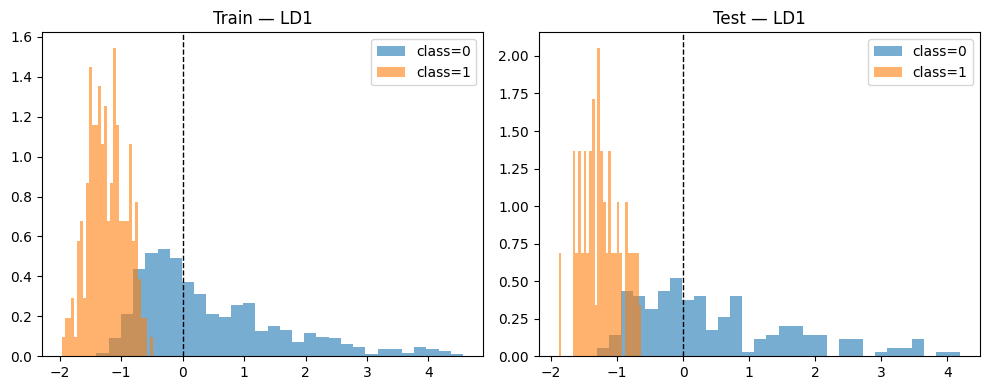

In [5]:

proj_tr = _read_csv_safe(files['proj_train'], index_col=0)
proj_te = _read_csv_safe(files['proj_test'],  index_col=0)

ld_cols = [c for c in proj_te.columns if c.lower().startswith('ld') or c.lower().startswith('score')]
ld1 = ld_cols[0] if ld_cols else proj_te.columns[0]

print('Using LD1 column:', ld1)

fig, ax = plt.subplots(1,2, figsize=(10,4))
if 'y' in proj_tr.columns:
    ax[0].hist(proj_tr[proj_tr['y']==0][ld1], bins=30, alpha=0.6, label='class=0', density=True)
    ax[0].hist(proj_tr[proj_tr['y']==1][ld1], bins=30, alpha=0.6, label='class=1', density=True)
    ax[0].axvline(0, color='k', ls='--', lw=1); ax[0].set_title('Train — LD1')
    ax[0].legend()
if 'y' in proj_te.columns:
    ax[1].hist(proj_te[proj_te['y']==0][ld1], bins=30, alpha=0.6, label='class=0', density=True)
    ax[1].hist(proj_te[proj_te['y']==1][ld1], bins=30, alpha=0.6, label='class=1', density=True)
    ax[1].axvline(0, color='k', ls='--', lw=1); ax[1].set_title('Test — LD1')
    ax[1].legend()
plt.tight_layout()
plt.show()


## 5) Saved figures (ROC & score histograms)

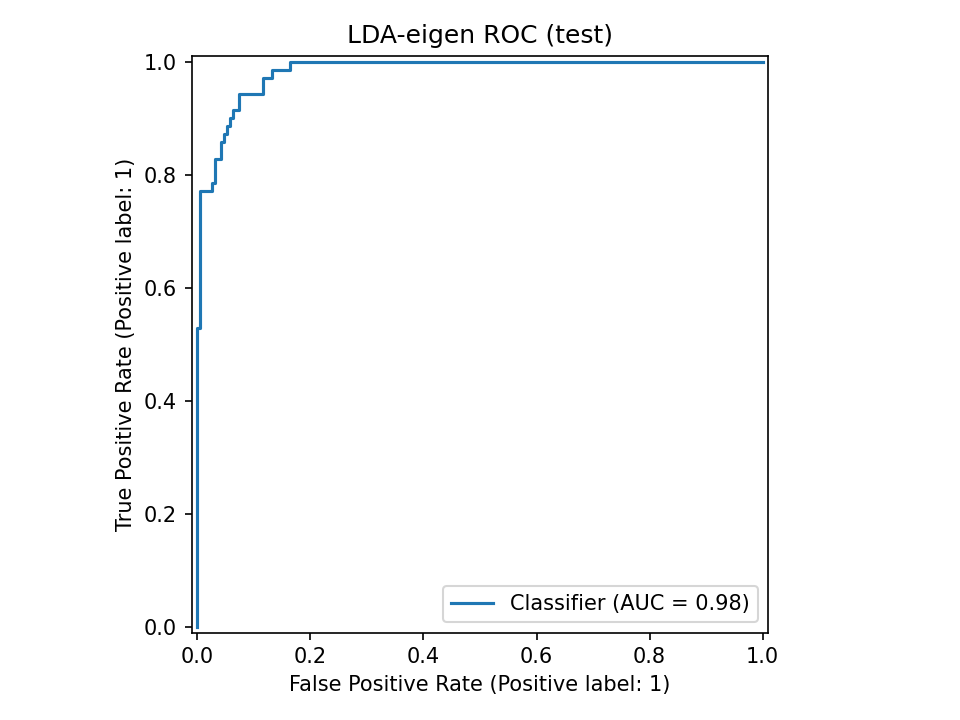

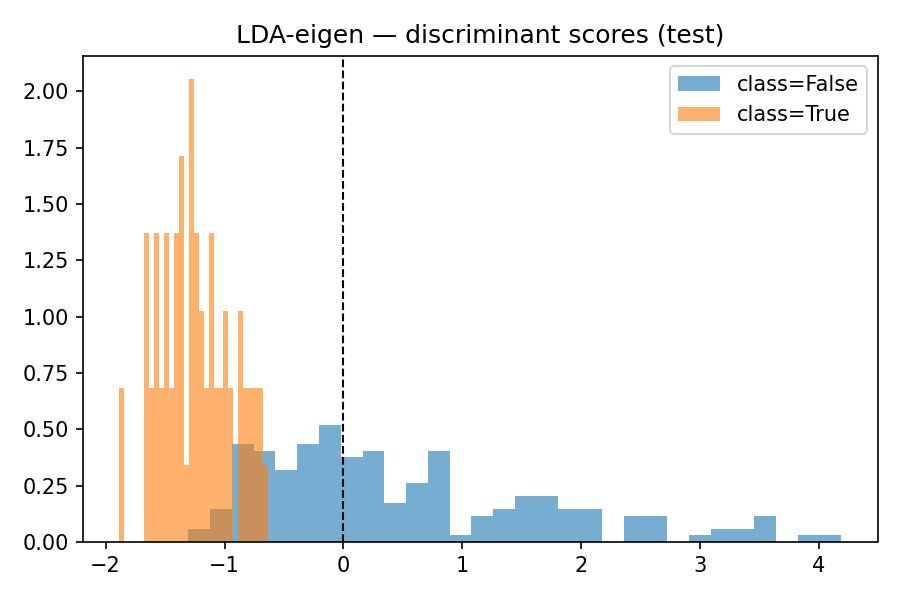

In [6]:

from IPython.display import Image, display
if files['roc_img'].exists():
    display(Image(filename=str(files['roc_img'])))
if files['scores_img'].exists():
    display(Image(filename=str(files['scores_img'])))


In [11]:

X_new_raw = pd.DataFrame([{
    "performance_score": 0.81,
    "co2_eq_emissions": 12.3,
    "likes": 0.0,
    "downloads": 120.0,
    "size": 4.9e8
}], index=["case_A"], columns=FEATURES)

pred_new = pd.DataFrame({
    "y_pred": pipe_lda.predict(X_new_raw),
    "p_true": pipe_lda.predict_proba(X_new_raw)[:, 1]
}, index=X_new_raw.index)
pred_new.to_csv("../../assets/lda_results_eigen/pred_new.csv")
pred_new

,y_pred,p_true
case_A,False,0.134459


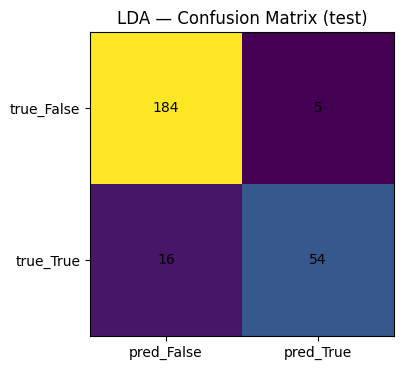

In [12]:
import pandas as pd, matplotlib.pyplot as plt
cm = pd.read_csv("../../assets/lda_results_eigen/LDA-eigen_confusion_test.csv", index_col=0)
fig, ax = plt.subplots(figsize=(4.2,3.8))
im = ax.imshow(cm.values)
ax.set_xticks(range(cm.shape[1])); ax.set_xticklabels(cm.columns, rotation=0)
ax.set_yticks(range(cm.shape[0])); ax.set_yticklabels(cm.index)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm.values[i,j]), ha="center", va="center")
ax.set_title("LDA — Confusion Matrix (test)")
plt.tight_layout(); plt.show()


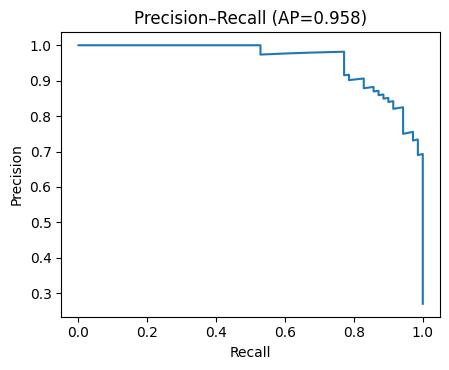

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np, pandas as pd

pred = pd.read_csv("../../assets/lda_results_eigen/LDA-eigen_pred_test.csv", index_col=0)  # o arma proba con pipe.predict_proba
y_true = pred["y_true"].astype(int).values
p_true = pred.filter(like="p_").iloc[:,1].values if "p_True" not in pred else pred["p_True"].values

prec, rec, thr = precision_recall_curve(y_true, p_true)
ap = average_precision_score(y_true, p_true)

import matplotlib.pyplot as plt
plt.figure(figsize=(4.6,3.8))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP={ap:.3f})")
plt.tight_layout(); plt.show()


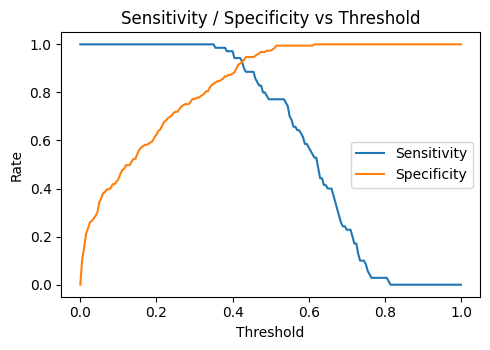

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

def sens_spec_at_threshold(y, p, thr):
    yhat = (p>=thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    sens = tp / (tp+fn) if tp+fn>0 else np.nan
    spec = tn / (tn+fp) if tn+fp>0 else np.nan
    return sens, spec

ths = np.linspace(0,1,201)
sens, spec = [], []
for t in ths:
    s1, s2 = sens_spec_at_threshold(y_true, p_true, t)
    sens.append(s1); spec.append(s2)

plt.figure(figsize=(5,3.6))
plt.plot(ths, sens, label="Sensitivity")
plt.plot(ths, spec, label="Specificity")
plt.xlabel("Threshold"); plt.ylabel("Rate")
plt.title("Sensitivity / Specificity vs Threshold")
plt.legend(); plt.tight_layout(); plt.show()


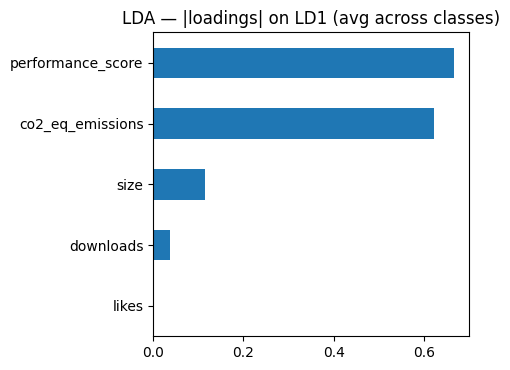

In [22]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
disc = pd.read_csv("../../assets/lda_results_eigen/LDA-eigen_discriminant_params.csv", index_col=0)
# Si tu LDA es binario, A_k para ambas clases difiere por constante; usa la magnitud promedio:
feat_cols = [c for c in disc.columns if c!="b_k"]
abs_mean = disc[feat_cols].abs().mean(axis=0).sort_values(ascending=True)
plt.figure(figsize=(5,3.8))
abs_mean.plot(kind="barh")
plt.title("LDA — |loadings| on LD1 (avg across classes)")
plt.tight_layout(); plt.show()
